# Semana 1: Exploración del problema y del dataset

## 1. Cargar y visualizar señales ECG

dict_keys(['val'])
(1, 9000)
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_adjust_datetime', '_arrange_fields', '_auto_signal_file_names', 'adc', 'adc_gain', 'adc_res', 'adc_zero', 'base_counter', 'base_date', 'base_datetime', 'base_time', 'baseline', 'block_size', 'byte_offset', 'calc_adc_gain_baseline', 'calc_adc_params', 'calc_checksum', 'check_field', 'check_field_cohesion', 'check_read_inputs', 'check_sig_cohesion', 'checksum', 'comments', 'convert_dtype', 'counter_freq', 'd_signal', 'dac', 'e_d_signal', 'e_p_signal', 'file_name', 'fmt', 'fs', 'get_absolute_time', 'get_elapsed_time', 'get_frame_number', 'get_write_fields', 'get_write_subset', 'init_value', 'n_sig', 'p_s

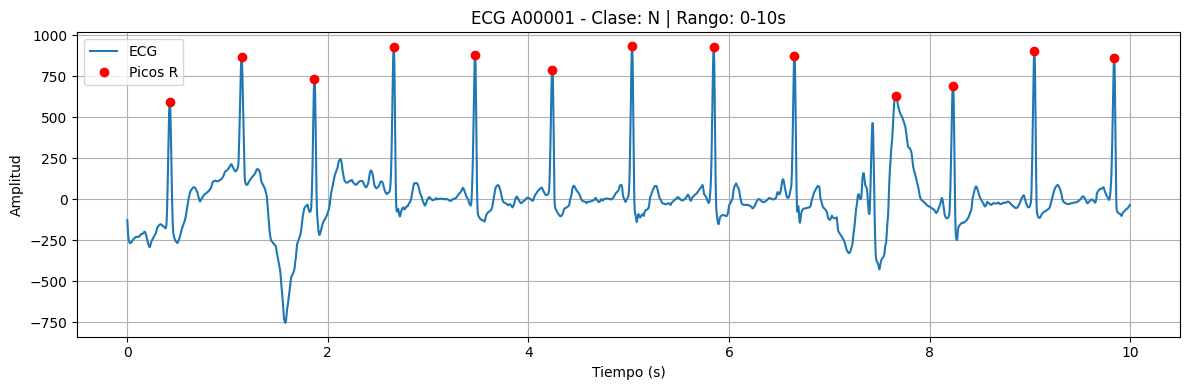

In [1]:
import os
import numpy as np
import scipy.io
from scipy.signal import find_peaks
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
import pandas as pd
import wfdb

# Configuración de parámetros
base_path = 'training2017' # Ruta base de los archivos
record_name = 'A00001' # Nombre del registro
output_csv = 'ecg_rr_features_curado.csv' # Archivo de salida para estadísticas

# Cargar archivo .mat
# Es un archivo MATLAB que puede contener variables omo arrays, escalares o strings
# En este caso, se usa para almacenar la señal ECG cruda 
# La señal se representa como un array de enteros, donde cada valor es un punto de la señal en el tiempo, basado en la frecuencia de muestreo
mat_file = os.path.join(base_path, f'{record_name}.mat')
mat_data = scipy.io.loadmat(mat_file)
print(mat_data.keys())  # Variables
signal = mat_data['val'][0]
print(mat_data['val'].shape) # Señal de 1 canal con 90000 muestras

# Cargar .hea 
# Es un archivo de texto plano que acomaña a cada señal fisiológica 
# Contiene metadatos como canales, frecuencia de muestreo, nombre del registro, etc.
header = wfdb.rdheader(os.path.join(base_path, record_name))
print(dir(header))  # Atributos del encabezado
fs = header.fs  # Frecuencia de muestreo

# Cargar etiquetas desde el archivo REFERENCE.csv
# Este archivo contiene la etiqueta de cada señal, por ejemplo, A00001,N
csv_labels = pd.read_csv(os.path.join(base_path, 'REFERENCE.csv'), header=None, names=['record', 'label'])
label = csv_labels.loc[csv_labels['record'] == record_name, 'label'].values[0] # Busca la etiqueta del registro 

# Rango a visualizar
start_sec = 0
end_sec = 10
start_idx = int(start_sec * fs) # Número de muestras (índice)
end_idx = int(end_sec * fs) 
signal_segment = signal[start_idx:end_idx] # Segmentar la señal
time_segment = np.arange(start_idx, end_idx) / fs

# Detección de picos R, usando umbral simple y distancia mínima
peaks, _ = find_peaks(signal_segment, distance=fs*0.3, height=np.mean(signal_segment) + np.std(signal_segment))

# Cálculo de intervalos RR (en milisegundos), a partir de los picos
rr_intervals = np.diff(peaks) / fs * 1000
print(f"Cantidad de picos: {len(peaks)}")
print(f"Intervalos RR (ms): {rr_intervals.round(1)}")

# Gráfico del segmento de ECG con los picos R detectados
plt.figure(figsize=(12, 4))
plt.plot(time_segment, signal_segment, label="ECG")
plt.plot(time_segment[peaks], signal_segment[peaks], 'ro', label="Picos R")
plt.title(f"ECG {record_name} - Clase: {label} | Rango: {start_sec}-{end_sec}s")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Recomendación: usar matplotlib, wfdb, scipy.io

## 2. Resumen del artículo base (Clifford et al., 2017)

La fibrilación auricular (AF) es la arritmia cardíaca sostenida más común y se caracteriza por una actividad eléctrica auricular desorganizada que impide la contracción efectiva de las aurículas. Desde el punto de vista electrocardiográfico, la AF se manifiesta por la ausencia de ondas P bien definidas y por una irregularidad en los intervalos RR, es decir, los intervalos entre latidos consecutivos. Esta irregularidad en los tiempos entre complejos QRS es uno de los indicadores más confiables de la presencia de AF, especialmente en registros de una sola derivación.

La importancia clínica de detectar AF radica en que está fuertemente asociada a un mayor riesgo de accidentes cerebrovasculares, insuficiencia cardíaca, deterioro cognitivo y muerte. Su prevalencia aumenta con la edad, alcanzando hasta un 15 % en adultos mayores. A menudo, la fibrilación auricular es asintomática o paroxística, lo que complica su diagnóstico oportuno. Se considera suficiente una grabación de al menos 30 segundos de fibrilación auricular documentada en ECG para confirmar el diagnóstico. Por esto, la monitorización continua con dispositivos portátiles es una herramienta clave para la detección temprana.

En ese contexto, el PhysioNet/CinC Challenge 2017 propuso el desarrollo de algoritmos automáticos capaces de detectar AF a partir de grabaciones cortas de ECG (30 a 60 segundos) de una sola derivación, simulando las condiciones reales de uso de dispositivos portátiles. El objetivo era clasificar cada grabación en una de cuatro clases: ritmo sinusal normal (N), fibrilación auricular (A), otros ritmos (O), y señales no utilizables por ruido (~). Los algoritmos debían ser robustos frente a condiciones adversas como ruido, artefactos por movimiento, variabilidad interindividual y baja duración de la señal. Una característica central para muchos enfoques fue el análisis de la variabilidad de los intervalos RR, ya que en la fibrilación auricular estos intervalos tienden a ser altamente irregulares, mientras que en el ritmo sinusal son más regulares.

El conjunto de datos entregado incluía más de 12.000 grabaciones de ECG, todas de una sola derivación y con una frecuencia de muestreo de 300 Hz. De ellas, 8.528 estaban disponibles públicamente para entrenamiento y validación, mientras que otras 3.658 fueron utilizadas para la evaluación final. Las duraciones de las grabaciones iban de 9 a 61 segundos y representaban una amplia gama de condiciones reales. Las señales provenían de dispositivos portátiles utilizados en entornos ambulatorios, lo que implicaba la presencia de ruido de baja y alta frecuencia, interferencias mecánicas y artefactos de movimiento. Las etiquetas fueron asignadas por expertos clínicos, aunque algunas grabaciones ambiguas fueron reevaluadas debido a discrepancias entre anotadores.

## 3. Análisis del dataset (cantidad de señales, duración, etiquetas, etc.)


Tipos de datos (etiqueta):
record    object
label     object
dtype: object

Clases:
label
N    5050
O    2456
A     738
~     284
Name: count, dtype: int64

Estadísticas:
Total de señales: 8528
Duración promedio: 32.50 s
Duración mínima: 9.05 s
Duración máxima: 60.95 s
Frecuencia de muestreo: {300} Hz
Señales con error: 0


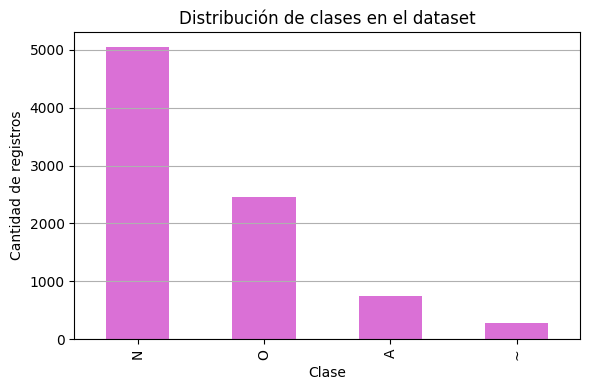

In [2]:
# Explorar tipos de datos en el archivo de etiquetas
print("\nTipos de datos (etiqueta):")
print(csv_labels.dtypes)

# Clases y cantidad de registros por clase 
print("\nClases:")
print(csv_labels['label'].value_counts())

durations = [] # Duración de cada señal
frequencies = [] # Frecuencia de muestreo de cada señal
errors = [] # Registros con errores

# Recorrer todos los registros
for rec in csv_labels['record']:
    try:
        header = wfdb.rdheader(os.path.join(base_path, rec))
        fs = header.fs
        sig_len = header.sig_len
        durations.append(sig_len / fs)
        frequencies.append(fs)
    except Exception as e:
        errors.append(rec)

# Mostrar estadísticas básicas
print("\nEstadísticas:")
print(f"Total de señales: {len(durations)}")
print(f"Duración promedio: {np.mean(durations):.2f} s")
print(f"Duración mínima: {np.min(durations):.2f} s")
print(f"Duración máxima: {np.max(durations):.2f} s")
print(f"Frecuencia de muestreo: {set(frequencies)} Hz")
print(f"Señales con error: {len(errors)}")

# Visualizar distribución de clases
plt.figure(figsize=(6, 4))
csv_labels['label'].value_counts().plot(kind='bar', color='orchid')
plt.title('Distribución de clases en el dataset')
plt.xlabel('Clase')
plt.ylabel('Cantidad de registros')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

## 3. Extracción de estadísticas

In [3]:
print("\nGenerar estadísticas:")

estadisticas = []

for _, row in csv_labels.iterrows():
    record = row['record']
    label = row['label']

    try:
        mat_data = scipy.io.loadmat(os.path.join(base_path, f'{record}.mat'))
        signal = mat_data['val'][0]

        # Detectar picos R
        peaks, _ = find_peaks(signal, distance=fs*0.3, height=np.mean(signal) + np.std(signal))
        rr = np.diff(peaks) / fs * 1000  # ms

        if len(rr) == 0:
            print(f"{record}: No se detectaron picos R")
            continue

        estadisticas.append({
            'record': record,
            'mean_rr': round(np.mean(rr), 2),
            'std_rr': round(np.std(rr), 2),
            'skew_rr': round(skew(rr), 2),
            'kurt_rr': round(kurtosis(rr), 2),
            'label': label
        })

    except Exception as e:
        print(f"{record}: {e}")

# Guardar CSV
df_rr = pd.DataFrame(estadisticas)
df_rr.to_csv(output_csv, index=False)
print(f"\n{output_csv} {len(df_rr)} registros")


Generar estadísticas:
A00013: No se detectaron picos R
A00252: No se detectaron picos R
A01421: No se detectaron picos R
A01890: No se detectaron picos R
A02135: No se detectaron picos R
A02513: No se detectaron picos R
A02747: No se detectaron picos R
A02989: No se detectaron picos R
A03074: No se detectaron picos R
A03087: No se detectaron picos R
A03549: No se detectaron picos R
A04155: No se detectaron picos R
A04270: No se detectaron picos R
A04399: No se detectaron picos R
A05548: No se detectaron picos R
A05784: No se detectaron picos R
A05904: No se detectaron picos R
A05914: No se detectaron picos R
A06288: No se detectaron picos R
A06636: No se detectaron picos R
A08502: No se detectaron picos R

ecg_rr_features_curado.csv 8507 registros
